## Inprocessing - Prejudice Remover -  Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import reset_default_graph
import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import prejudice_remover_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3, best_hyperparameter_advdeb
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold


/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

## Build up the function using race

In [3]:
from aif360.algorithms.inprocessing import PrejudiceRemover

# 1) Load COMPAS (race) data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    train_bld = BinaryLabelDataset(
        df=train_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    test_bld = BinaryLabelDataset(
        df=test_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    
    # Train PrejudiceRemover (η = 25.0 default) 
    pr = PrejudiceRemover(eta=25.0, sensitive_attr=protected)
    pr = pr.fit(train_bld)

    pred_bld = pr.predict(test_bld)

    y_test = test_bld.labels.ravel()
    y_pred = pred_bld.labels.ravel()

    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics     = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.675260  0.623242 -0.118721  0.738756 -0.133634 -0.095520
std   0.012722  0.019111  0.032650  0.068487  0.038646  0.030315


--------------------------------------------------------------------------------------------------------------------------------------

## default prejudice remover, sex

In [4]:
# 1) Load data
protected          = 'sex'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_sex()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
    df, train_idx, test_idx,
    protected, privileged_value, unprivileged_value,
    eta=25.0
    )
        
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_sex_metrics     = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean', 'std'])
print(compas_sex_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.675925  0.608515 -0.259834  0.392978 -0.293340 -0.235861
std   0.011675  0.013848  0.032404  0.065219  0.047551  0.034308


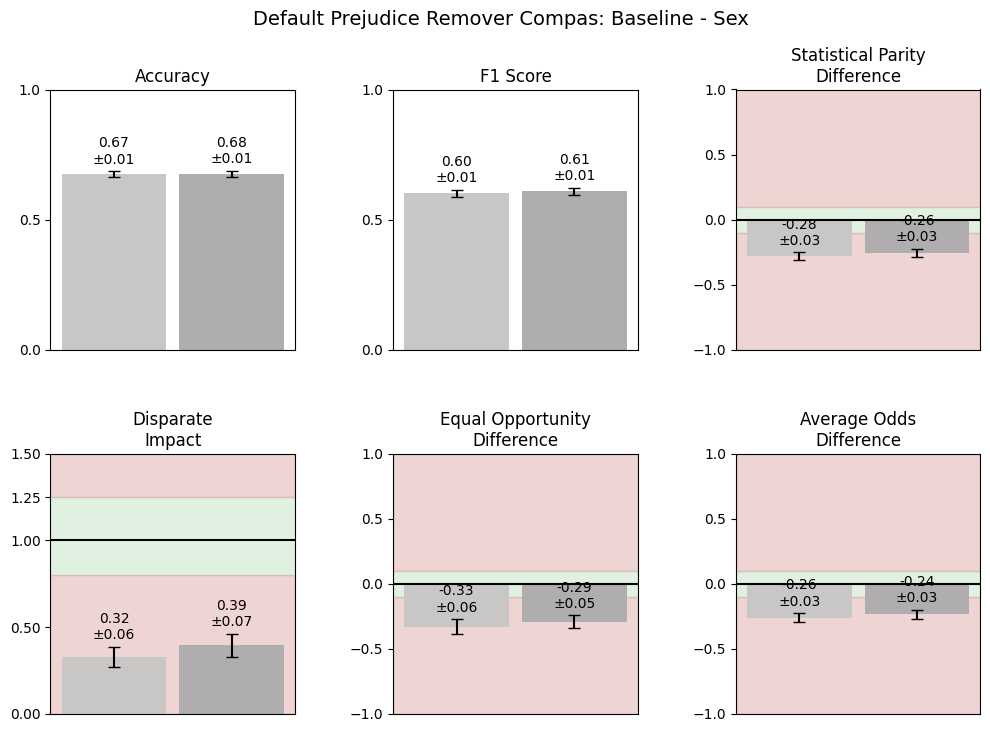

In [5]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Sex', 'Default Prejudice Remover Compas: Baseline - Sex')

## default prejudice remover, race

In [6]:
# 1) Load data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
    df, train_idx, test_idx,
    protected, privileged_value, unprivileged_value,
    eta=25.0
    ) 
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics     = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.675260  0.623242 -0.118721  0.738756 -0.133634 -0.095520
std   0.012722  0.019111  0.032650  0.068487  0.038646  0.030315


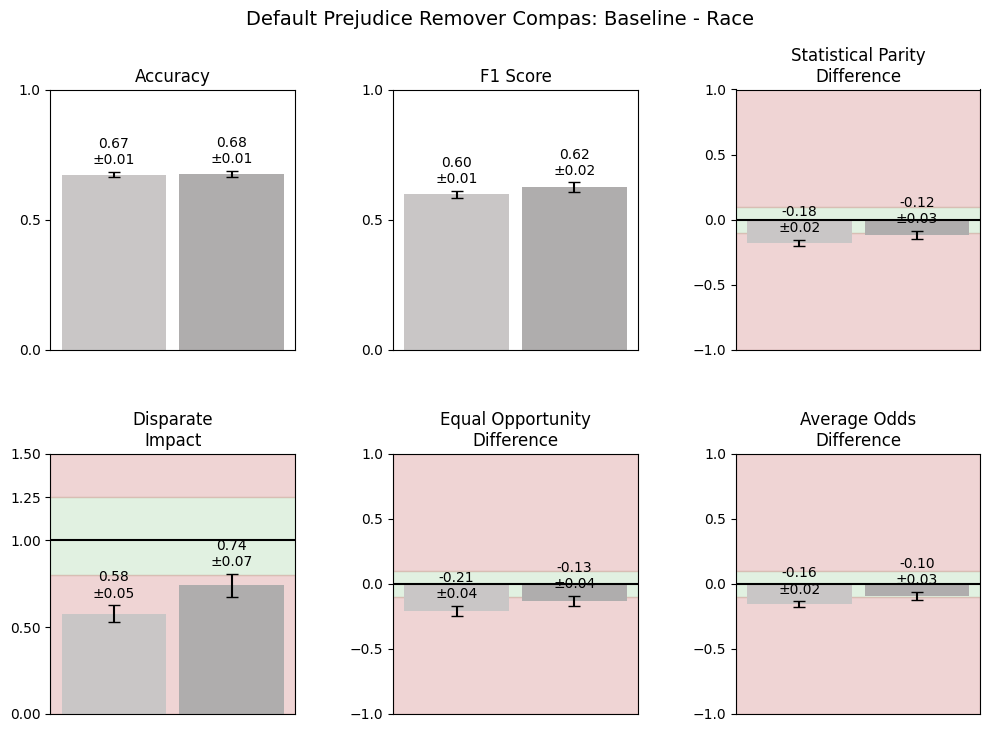

In [7]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Default Prejudice Remover Compas: Baseline - Race')

## hyperparameter search adversial debiaser, race

In [8]:
# 1) Load data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Sweep η grid
eta_grid = [15.0, 25.0, 40.0, 60.0]
grid_results = []
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

for eta in eta_grid:
    fold_metrics = []
    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = prejudice_remover_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            eta=eta
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)

    agg = pd.DataFrame(fold_metrics).agg(['mean','std'])
    grid_results.append({
        'eta':      eta,
        'acc_mean': agg.loc['mean','accuracy'],
        'SPD_mean': agg.loc['mean','SPD'],
        'DI_mean':  agg.loc['mean','DI'],
        # add other metrics as needed...
    })

results_df = pd.DataFrame(grid_results)

# 3) Pick best
best_row = best_hyperparameter_advdeb(results_df)
chosen_eta = best_row['eta']
print(f"Chosen eta: {chosen_eta}")

# 4) Final evaluation with PrejudiceRemover
final_metrics = []
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)
for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        eta=chosen_eta
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    final_metrics.append(m)

# 5) Aggregate 
compas_race_metrics     = pd.DataFrame(final_metrics)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])
print(compas_race_metrics_agg)


Chosen eta: 60.0
      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.670637  0.595057 -0.035210  0.905301 -0.036528 -0.011346
std   0.024770  0.038442  0.064015  0.169579  0.105294  0.061105


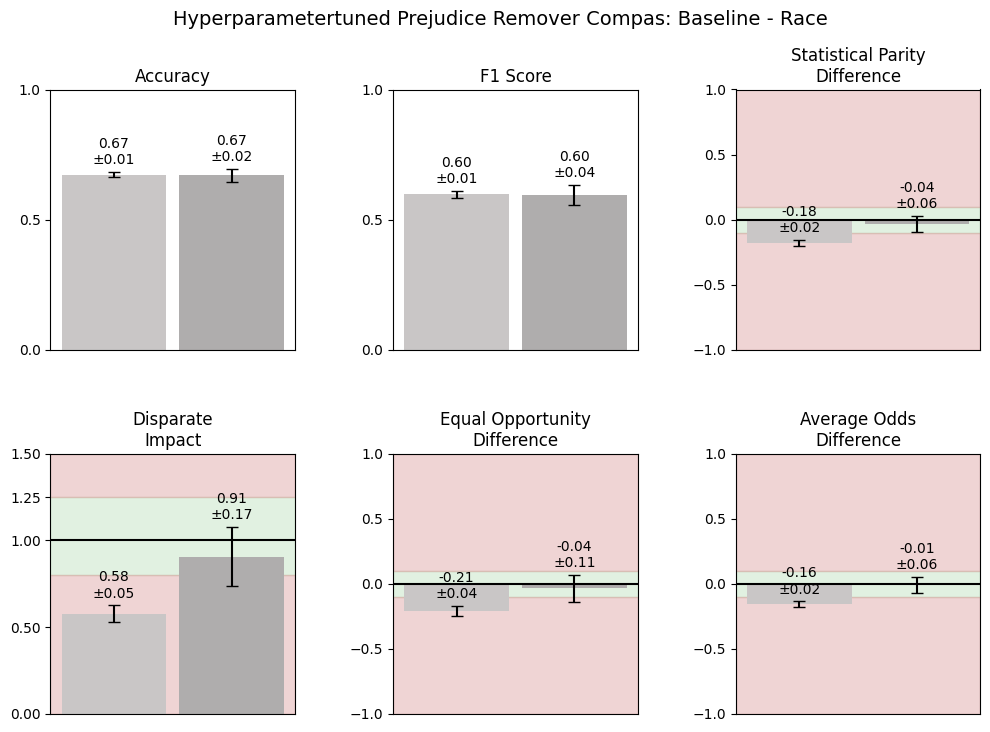

In [9]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Hyperparametertuned Prejudice Remover Compas: Baseline - Race')

## hyperparameter search adversial debiaser, race

In [10]:
# 1) Load data
protected          = 'sex'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_sex()
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Sweep η grid
eta_grid = [15.0, 25.0, 40.0, 60.0]
grid_results = []
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

for eta in eta_grid:
    fold_metrics = []
    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = prejudice_remover_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            eta=eta
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)

    agg = pd.DataFrame(fold_metrics).agg(['mean','std'])
    grid_results.append({
        'eta':      eta,
        'acc_mean': agg.loc['mean','accuracy'],
        'SPD_mean': agg.loc['mean','SPD'],
        'DI_mean':  agg.loc['mean','DI'],
        # add other metrics as needed...
    })

results_df = pd.DataFrame(grid_results)

# 3) Pick best
best_row = best_hyperparameter_advdeb(results_df)
chosen_eta = best_row['eta']
print(f"Chosen eta: {chosen_eta}")

# 4) Final evaluation with PrejudiceRemover
final_metrics = []
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)
for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        eta=chosen_eta
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    final_metrics.append(m)

# 5) Aggregate 
compas_sex_metrics     = pd.DataFrame(final_metrics)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean','std'])
print(compas_sex_metrics_agg)


Chosen eta: 15.0
      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.676035  0.607217 -0.265622  0.380763 -0.298509 -0.240846
std   0.027607  0.036970  0.059919  0.116856  0.134589  0.073749


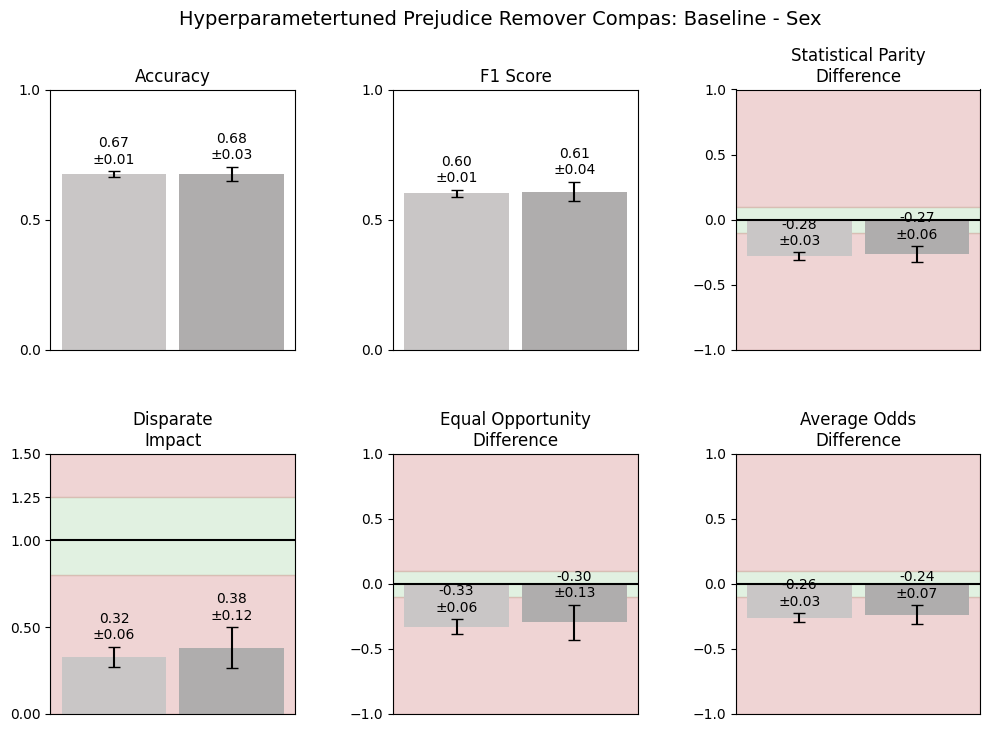

In [11]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Sex', 'Hyperparametertuned Prejudice Remover Compas: Baseline - Sex')